In [1]:
import os
import sys
import dask
import uproot4
import numpy as np
import pandas as pd
from hist import Hist
import hist
import uproot4 as uproot
from dask.array import histogram as ds_hist
import dask.dataframe as dd
import timeit
from distributed import Client
import Histogramming.storage_functions as sf
import time
import psutil
import matplotlib.pyplot as plt
import pyarrow as pa
import re
import subprocess
from pympler import asizeof
import Histogramming.hist_vars as hist_vars
import itertools
import Histogramming.hist_wrapper as hist_wrapper
from hurry.filesize import size
import pyarrow.parquet as pq
import Histogramming.test as tt
import histogramming_config as hc


In [2]:
len(hc.Samples[1].file_list)

19

In [3]:
2*10**6

2000000

In [4]:
hist_vars.var_main['rljet_pt_comb']

Regular(20, 300000, 600000, name='x', label='$p_{T}$[MeV]')

In [5]:
dask.config.set({'temporary_directory': '/tmp/kmalirz'})

In [6]:
delayed_dict, client, names, out_linear, names_linear = tt.fill_all()

Client Dashboard: http://127.0.0.1:8787/status


In [7]:
#delayed_dict = tt.combine_partitions(delayed_dict)

In [8]:
names[0][1][10]

('/eos/atlas/atlascerngroupdisk/perf-jets/JSS/WTopBackgroundSF2019/UFO_test/slimmed_SEP_v2/user.brle.periodF.physics_Main.DAOD_JETM6.grp16_v01_p4309.data_gammajet_210921_data_v1_output_root_15.h5',
 [('high_pt', ['test']),
  ('low_pt', ['test']),
  ('default', ['test']),
  ('test1', ['test']),
  ('test2', ['test']),
  ('test3', ['test']),
  ('test4', ['test']),
  ('test5', ['test'])])

In [9]:
len(out_linear)

280

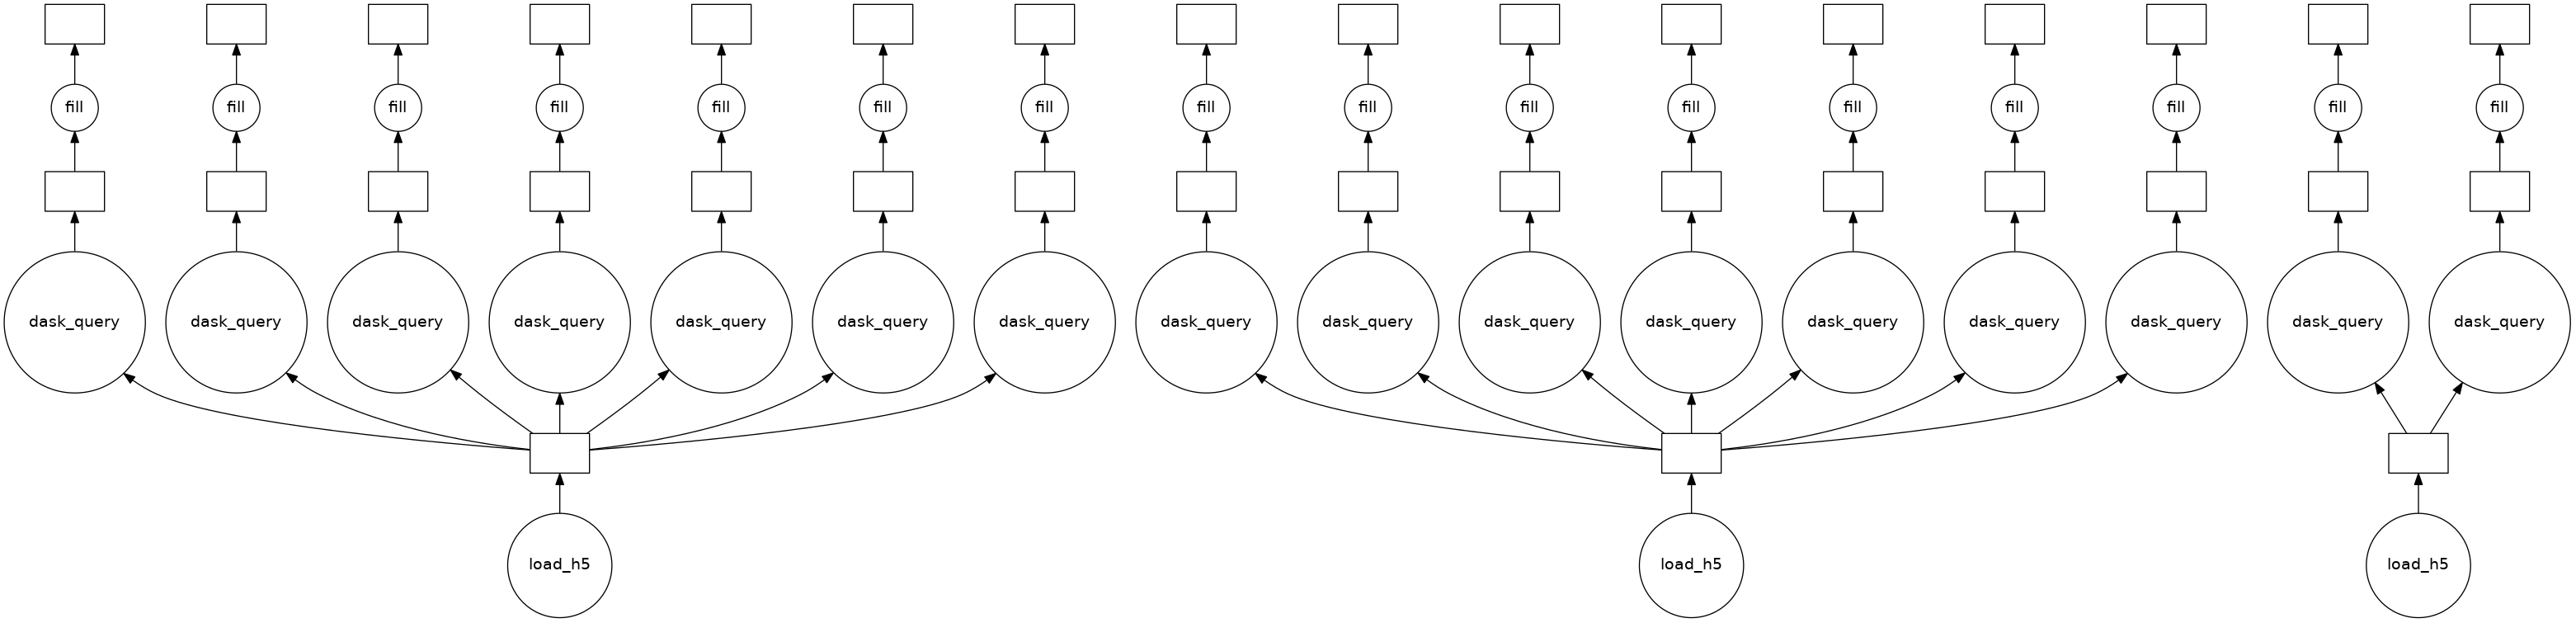

In [10]:
dask.visualize(out_linear[:16])

In [11]:
len(names_linear)

280

In [12]:
delayed_dict[0][1]

[[Delayed('fill-88ed9c47-026e-445c-92b7-18651d6c455e')],
 [Delayed('fill-be00b14c-ef15-457a-95ea-1e405c85e7a3')],
 [None],
 [Delayed('fill-94415cbc-a4fd-4a8b-9012-eddcfbc3eeac')],
 [Delayed('fill-774174a9-4fdc-432a-81fc-fa077f229609')],
 [Delayed('fill-702b1232-528c-4a1d-8763-e177ff51d01a')],
 [Delayed('fill-7aaad2a1-33c5-4437-98fd-46eefabc5b84')],
 [Delayed('fill-dd039f64-f702-4246-8ce1-ca417d2d9b6b')]]

In [13]:
%%time
temp = dask.compute(out_linear)[0]

CPU times: user 4.12 s, sys: 736 ms, total: 4.85 s
Wall time: 7.84 s


In [14]:
temp[0][0]

Hist(Regular(20, 300000, 600000, name='x', label='$p_{T}$[MeV]'), storage=Double()) # Sum: 194.0 (227.0 with flow)

In [15]:
a = tt.combine_samples(temp,names_linear)

In [16]:
a['test1']['high_pt']['test']['rljet_pt_comb']

Hist(Regular(20, 300000, 600000, name='x', label='$p_{T}$[MeV]'), storage=Double()) # Sum: 3932.0 (4885.0 with flow)

In [17]:
temp[0][0]

Hist(Regular(20, 300000, 600000, name='x', label='$p_{T}$[MeV]'), storage=Double()) # Sum: 194.0 (227.0 with flow)

In [18]:
val = temp[0][0].copy()
for h, name in zip(temp,names_linear):
    
    if name.sample == 'test1' and name.region == 'high_pt' and name.systematic == 'test' and name.file != names_linear[0].file:
        
        val = val + h[0]
        
        
        

In [19]:
val

Hist(Regular(20, 300000, 600000, name='x', label='$p_{T}$[MeV]'), storage=Double()) # Sum: 3932.0 (4885.0 with flow)

In [20]:
a[0][0][0][0]

KeyError: 0

In [ ]:
names[1][0]

In [ ]:
names[1][1][0][1][0][1]

In [ ]:
dic = {}
dic[names[1][0]] = {}
dic[names[1][0]][names[1][1][0][1][0][0]] = 'x'

In [ ]:
dic

In [ ]:
print1

In [ ]:
testing = []
for i in range(0,3):
    
    for item in delayed_dict[0][i]:
        testing.append(item[0])
    

In [ ]:
%%time
temp = dask.compute(testing)[0]

In [ ]:
%%time
temp = dask.compute(delayed_dict[0][0:20])[0]

In [ ]:
temp[0][0][0][0]

In [ ]:
(delayed_dict[0][0:300][0])

In [ ]:
dask.visualize(delayed_dict[0][0][0])

In [ ]:
temp

In [ ]:
testing

In [ ]:
delayed_dict[0][0]

In [ ]:
dask.visualize(testing[0:8])

In [ ]:
len(delayed_dict[0])

In [ ]:
temp[1][0][0][0]

In [ ]:
temp[0][0][0][0]

In [ ]:
(431323+388619+341127+296292+257391+223628+198275+175785+159549+148516+836218+757282+673852+600882+536209+477217+421328+370799+325041+285276)/(4223797+4013917)

In [ ]:
client.close()

In [ ]:
(Hist(hist.axis.Regular(20, 300000, 600000, name='x', label='$p_{T}$[MeV]')))

In [ ]:
#(sf.Histogram_wrapper(hist.axis.Regular(20, 300000, 600000, name='x', label='$p_{T}$[MeV]'),name='x'))

In [ ]:
histo_var_dict = sf.combine_dicts([hist_vars.var_main, hist_vars.var_series, hist_vars.var_beta, 
                               hist_vars.var_ecf_beta, hist_vars.var_dichoric, hist_vars.var_ecfg])

In [ ]:
#histo_var_dict = dict(itertools.islice(histo_var_dict.items(), 10))

In [ ]:
len(histo_var_dict)

In [ ]:
histogramming = sf.HistoMaker()

In [ ]:
client = histogramming.client_start(n_workers = 4,memory_limit='5GB',threads_per_worker=1)

In [ ]:
client

In [ ]:
client.dashboard_link

In [ ]:

x = histogramming.create_file_list(top_directory = '/eos/atlas/atlascerngroupdisk/perf-jets/JSS/WTopBackgroundSF2019/UFO_test/slimmed_SEP_v2/',file_regex = '(?=^[^.].)(.*gammajet_210921.*|.*15.*)(.*h5$)')

In [ ]:
size(sum([os.path.getsize(y) for y in x[:]]))

In [ ]:
#size(file_size)

In [ ]:
len(x)

In [ ]:
x[10]

In [ ]:
data = histogramming.load_h5(x[10])

In [ ]:
test = data.compute()

In [ ]:
test['rljet_pt_comb'].describe()

In [ ]:
test

In [ ]:
table = pa.Table.from_pandas(test)

pq.write_table(table, '/tmp/kmalirz/example.parquet')

table2 = pq.read_table('/tmp/kmalirz/example.parquet')

table2.to_pandas().head(10)

In [ ]:
df = dd.read_parquet('/tmp/kmalirz/example.parquet')

df

In [ ]:
df = df.repartition(npartitions=2)

df.npartitions

In [ ]:
df.partitions[0].compute()

In [ ]:
histogramming.histogram_variables

In [ ]:
zzzzzz = data.compute()

In [ ]:
zzzzzz

In [ ]:
output = dask.compute(histogramming.fill(data,histo_var_dict))

In [ ]:
output

In [ ]:
dask.visualize(histogramming.load_and_fill(file_list = x[:10]))

In [ ]:
#%%time
#temp = dask.compute(histogramming.load_and_fill(data_column = 'rljet_pt_comb',file_list = x[:200]))

In [ ]:
%%time
xxxxx = histogramming.compute_histograms(chunk_size = 100, histogram_variables = histo_var_dict, file_list = x[:])

In [ ]:
a = histogramming.histograms_computed[1][0]
b = histogramming.histograms_computed[0][0]

a+b

In [ ]:
len(histogramming.histograms_computed)


In [ ]:
zzz, histograms_named = histogramming.combine_histograms()



In [ ]:
histograms_named


In [ ]:
len(histograms_named)

In [ ]:
zzz[0]

In [ ]:
for attribute, value in zzz[20].__dict__.items():
    print(attribute, '=', value)

In [ ]:
len(xxxxx)

In [ ]:
xxxxx[0][0]

In [ ]:
min([len(x) for x in xxxxx])

In [ ]:
#dask.visualize(histogramming.load_and_fill(data_column = 'rljet_pt_comb',file_list = x[:4]))

In [ ]:
psutil.virtual_memory().percent

In [ ]:
%%time
histogram_list = []
i = -1
for file in x[:20]:
    temp = pd.read_hdf(file)
    col_list = list(temp.columns)
    histogram_list.append([])
    i += 1
    for col in col_list:
        
        if histo_var_dict.get(col) != None:
            
            ssss = hist.Hist(histo_var_dict[col])
            ssss.fill(temp[col])
            histogram_list[i].append(ssss)
        
        

In [ ]:
histogram_list[0][1]

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.title("Sphericity Plot")
histogram_list[0][1].plot1d(ax=ax, ls="-", color="teal", lw=2)
plt.savefig("plot_test.jpeg")
plt.show()

In [ ]:
type(ax)